# 日本国内のコロナ感染者数を予測します

# 実行に必要なライブラリをインストールします。


In [1]:
!pip install --upgrade pip

Requirement already up-to-date: pip in /home/nbuser/anaconda3_501/lib/python3.6/site-packages (20.1)


In [2]:
!pip install pystan

     |████████████████████████████████| 67.3 MB 13 kB/s  eta 0:00:011     |████████▎                       | 17.4 MB 24.4 MB/s eta 0:00:03     |██████████                      | 21.2 MB 24.4 MB/s eta 0:00:02   | 41.8 MB 43.1 MB/s eta 0:00:01     |█████████████████████████▋      | 53.9 MB 8.9 MB/s eta 0:00:02


In [3]:
!pip install fbprophet==0.5

     |████████████████████████████████| 49 kB 346 kB/s eta 0:00:01
     |████████████████████████████████| 43 kB 91 kB/s  eta 0:00:011
     |████████████████████████████████| 110 kB 11.6 MB/s eta 0:00:01
     |████████████████████████████████| 732 kB 32.2 MB/s eta 0:00:01
  Created wheel for fbprophet: filename=fbprophet-0.5-py3-none-any.whl size=6465682 sha256=ec229c430b19d1285d6ea4d50b41084084451202040206e965c76083ac2332b7
  Stored in directory: /home/nbuser/.cache/pip/wheels/90/10/ce/638be5c5af73565e96e4e995b058a59c11f19854c02671b6c3
  Created wheel for holidays: filename=holidays-0.10.2-py3-none-any.whl size=117707 sha256=958da5f696d24bd9008929eaa7b1bb0bf469637a4027086a675c125755df010e
  Stored in directory: /home/nbuser/.cache/pip/wheels/14/8c/59/ae0537ab5b492f1c85a8a010196baff43e2abbea20b2cfb74c
  Created wheel for pymeeus: filename=PyMeeus-0.3.7-py3-none-any.whl size=691116 sha256=3d7cdf660420f150c249b98a3b4367bf938b4b27a049e3b14ab97efdb0d85651
  Stored in directory: /home/nbuse

In [4]:
!pip install holidays==0.9.12

     |████████████████████████████████| 85 kB 344 kB/s eta 0:00:01
  Created wheel for holidays: filename=holidays-0.9.12-py3-none-any.whl size=53383 sha256=89fa43485c333b5ba165ec19f334b4604507dcbf03d77591c8b0d3bf29d871a0
  Stored in directory: /home/nbuser/.cache/pip/wheels/02/33/ad/d2536fe7f536284398d86acc7bd9fb3d2a9eabbd66050c2e2b
Successfully built holidays
  Attempting uninstall: holidays
    Found existing installation: holidays 0.10.2
    Uninstalling holidays-0.10.2:
      Successfully uninstalled holidays-0.10.2


In [5]:
!pip install plotly==4.6

     |████████████████████████████████| 7.1 MB 2.3 MB/s eta 0:00:01
  Attempting uninstall: plotly
    Found existing installation: plotly 4.2.1
    Uninstalling plotly-4.2.1:
      Successfully uninstalled plotly-4.2.1


In [6]:
!pip install japanmap

     |████████████████████████████████| 167 kB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 28.2 MB 100 kB/s eta 0:00:01
  Created wheel for japanmap: filename=japanmap-0.0.21-py3-none-any.whl size=168038 sha256=de86b624d589e2bf209530419351729ec3a23272af41be3daf0ec35832cc30aa
  Stored in directory: /home/nbuser/.cache/pip/wheels/fe/27/1a/f97135403d1bcba8dbf37280d2da510532c136bcf1c9ac123b
Successfully built japanmap


In [27]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
import plotly
from datetime import date, timedelta
import datetime
from datetime import datetime as dt
import math
df = pd.read_csv("./covid19.csv")

df.dropna(subset=['確定日YYYYMMDD'], inplace=True)
df.dropna(subset=['通し'], inplace=True)
for i in ['Field2', 'Field4', 'Field5','Field6','Field7','Field8','Field9' ,'Field10']:
    del df[i]

In [28]:
display(df)

,通し,厚労省NO,無症状病原体保有者,国内,チャーター便,年代,性別,確定日,発症日,受診都道府県,...,Hospital Pref,Residential Pref,Release,Gender,X,Y,確定日YYYYMMDD,受診都道府県コード,居住都道府県コード,更新日時
0,1.0,1,NaN,A-1,NaN,30,男性,1/15/2020,1/3/2020,神奈川県,...,Kanagawa,Kanagawa,Kanagawa Prefecture,Male,139.642347,35.447504,2020/1/15,14.0,14.0,5/15/2020 12:29
1,2.0,2,NaN,A-2,NaN,40,男性,1/24/2020,1/14/2020,東京都,...,Tokyo,China(Mainland),Tokyo Metropolitan Government,Male,116.409685,39.903832,2020/1/24,13.0,NaN,NaN
2,3.0,3,NaN,A-3,NaN,30,女性,1/25/2020,1/21/2020,東京都,...,Tokyo,China(Mainland),Tokyo Metropolitan Government,Female,116.409685,39.903832,2020/1/25,13.0,NaN,NaN
3,4.0,4,NaN,A-4,NaN,40,男性,1/26/2020,1/23/2020,愛知県,...,Aichi,China(Mainland),Aichi Prefecture,Male,116.409685,39.903832,2020/1/26,23.0,NaN,NaN
4,5.0,5,NaN,A-5,NaN,40,男性,1/28/2020,1/22/2020,愛知県,...,Aichi,China(Mainland),Aichi Prefecture,Male,116.409685,39.903832,2020/1/28,23.0,NaN,NaN
5,6.0,6,NaN,A-6,NaN,60,男性,1/28/2020,1/14/2020,奈良県,...,Nara,Nara,MHLW,Male,135.832745,34.685295,2020/1/28,29.0,29.0,NaN
6,7.0,7,NaN,A-7,NaN,40,女性,1/28/2020,1/26/2020,北海道,...,Hokkaido,China(Mainland),Hokkaido Prefecture,Female,116.409685,39.903832,2020/1/28,1.0,NaN,NaN
7,8.0,8,NaN,A-8,NaN,40,女性,1/29/2020,1/20/2020,大阪府,...,Osaka,Osaka,Osaka Prefecture,Female,135.519920,34.685972,2020/1/29,27.0,27.0,NaN
8,9.0,9,NaN,NaN,B-1,50,男性,1/30/2020,1/29/2020,不明,...,Unknown,China(Mainland),MHLW,Male,116.409685,39.903832,2020/1/30,NaN,NaN,NaN
9,10.0,-,チャーター無症状2,NaN,NaN,50,女性,1/30/2020,NaN,千葉県,...,Chiba,China(Mainland),Chiba Prefecture,Female,116.409685,39.903832,2020/1/30,12.0,NaN,NaN


In [29]:
df.isnull().sum()

通し                      0
厚労省NO               12708
無症状病原体保有者           15517
国内                  15873
チャーター便              16164
年代                      1
性別                      0
確定日                     0
発症日                  7521
受診都道府県                  0
居住都道府県                  0
居住管内                15944
居住市区町村               6783
キー                      0
発表                      0
都道府県内症例番号             689
市町村内症例番号            12770
ステータス               15690
備考                  14419
ソース                 13633
ソース2                 4016
ソース3                12895
人数                      0
累計                  16064
前日比                 16064
発症数                 16064
死者合計                16085
退院数累計               16081
退院数                 16081
PCR検査実施人数           16103
PCR検査前日比            16105
職業_正誤確認用            15257
勤務先_正誤確認用           16120
Hospital Pref           0
Residential Pref        0
Release                 0
Gender                  0
X                       0
Y           

In [30]:
df["確定日datetime"] = [dt.strptime(str(i), '%Y/%m/%d') for i in df["確定日YYYYMMDD"]]
dates = pd.DataFrame(data=pd.date_range('2020-1-15', periods=(datetime.datetime.strptime(df["確定日YYYYMMDD"][-2:-1].values[0], '%Y/%m/%d') - datetime.datetime.strptime(df["確定日YYYYMMDD"][0], '%Y/%m/%d')).days), columns=["確定日datetime"])
# dates["確定日YYYYMMDD"] =[str(i)[:-9].replace("-", "/") for i in dates["確定日YYYYMMDD"]]
# dates = dates.astype("str")
date_df = pd.merge(df, dates, on='確定日datetime', how='outer')
date_df["人数"] = [0 if math.isnan(i) else i for i in date_df["人数"]]
df = date_df
date_df = date_df.sort_values("確定日datetime")

In [31]:
import plotly
plotly.__version__


'4.6.0'

In [32]:
def total_keepnoindex(d):
    return pd.DataFrame({
        'total': d["人数"].sum()
    }, index=[0])

def Cumulative_sum(d):
    
    return pd.DataFrame({
        'total': d["total"].sum()
    }, index=[0])

In [33]:
df_sum = df[["年代", "性別", "人数", "居住都道府県"]].groupby(["年代", "性別", "居住都道府県"]).apply(total_keepnoindex)
df_sum.reset_index()

,年代,性別,居住都道府県,level_3,total
0,0-10,不明,京都府,0,1.0
1,0-10,不明,山口県,0,1.0
2,0-10,不明,東京都,0,1.0
3,0-10,不明,神奈川県,0,1.0
4,0-10,不明,静岡県,0,3.0
5,0-10,女性,三重県,0,4.0
6,0-10,女性,京都府,0,2.0
7,0-10,女性,兵庫県,0,3.0
8,0-10,女性,北海道,0,4.0
9,0-10,女性,千葉県,0,3.0


In [34]:
df_count_by_place = df[["年代", "性別", "居住都道府県","人数"]].groupby(["年代", "性別", "居住都道府県"]).count().reset_index().sort_values("年代")
import plotly.express as px
px.sunburst(df_count_by_place, path=['居住都道府県', '年代', '性別'], values='人数')

In [35]:
import plotly.graph_objects as go

fig = go.Figure()

df_sum = df[["人数", "居住都道府県"]].groupby(["居住都道府県"]).apply(total_keepnoindex)
df_sum = df_sum.reset_index().sort_values("total")
del df_sum['level_1']

for i in df_sum.values:
    fig.add_trace(go.Bar(
        x=[i[1]],
        y=[i[0]],
        name='Primary Product',
        marker_color='indianred',
        orientation='h'))

fig.update_layout(
    title="感染が報告されている都道府県",
    xaxis_title="感染者数",
    yaxis_title="",
 # templateを指定するだけで勝手に黒を基調としたグラフになる
    template="plotly_dark",
    )
fig.show()

In [49]:
df_day_count = df[["人数", "居住都道府県", "確定日YYYYMMDD", "確定日datetime"]].groupby(["確定日datetime","居住都道府県", "確定日YYYYMMDD"]).apply(total_keepnoindex)
df_day_count = df_day_count.reset_index().sort_values("居住都道府県")
del df_day_count['level_3']


df_day_count = df_day_count.reset_index().sort_values("居住都道府県")
df_day_count = df_day_count.sort_values("確定日datetime")
df_day_count["total"] = df_day_count[["total", "居住都道府県", "確定日YYYYMMDD"]].groupby(["居住都道府県"]).cumsum()

df_day_count["確定日YYYYMMDD"] = [datetime.datetime.strptime(i, "%Y/%m/%d") for i in df_day_count["確定日YYYYMMDD"]]

df_day_count = df_day_count.sort_values("確定日YYYYMMDD")
fig = go.Figure()
for i in df_day_count["居住都道府県"].unique():
    
    fig.add_trace(
        go.Scatter(x=df_day_count[df_day_count["居住都道府県"] == i]["確定日YYYYMMDD"], y=df_day_count[df_day_count["居住都道府県"] == i]["total"],
                    mode='lines',
                    name=i)
                 )

fig.update_layout(
    title="感染が報告されている都道府県(国籍)",
    xaxis_title="日次感染者数",
    yaxis_title="",
 # templateを指定するだけで勝手に黒を基調としたグラフになる
    template="plotly_dark",
    )
fig.show()

多くの都道府県で緊急事態宣言が出されてから感染者の増加が緩やかになったことがわかります。

# コロナウイルス日次の発症者数予測

In [46]:
from datetime import datetime as dt

data = df.copy()
# df_data = [i.split("/") for i in data["確定日YYYYMMDD"]]
# data["確定日YYYYMMDD"] = [i[0] + "-" + i[1] +  "-" + i[2] for i in df_data]

df_sum = df[["人数", "確定日datetime"]].groupby(["確定日datetime"]).apply(total_keepnoindex)
df_sum = df_sum.reset_index().sort_values("total")
del df_sum['level_1']

day_dict = {}
for i in df_sum.values:
    day_dict[i[0]] = i[1]
        
data["total"] = [day_dict[i] if i in day_dict.keys() else np.nan for i in data["確定日datetime"]]

## 1日の感染者数

In [13]:
Number_of_cases = data.copy()
Number_of_cases = Number_of_cases.rename(columns={'確定日YYYYMMDD': 'ds', 'total': 'y'})
Number_of_cases["ds"] = [pd.to_datetime(i)for i in Number_of_cases["ds"]]
Number_of_cases = Number_of_cases[["ds", "y"]].set_index("ds").resample('D').mean().reset_index()
Number_of_cases["y"] = Number_of_cases["y"].fillna(0)
Number_of_cases

fig = px.line(Number_of_cases, x='ds', y='y')
fig.show()

## 感染者数予測

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


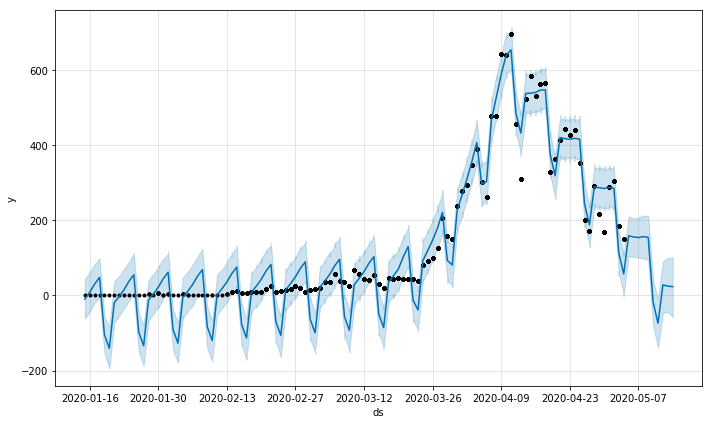

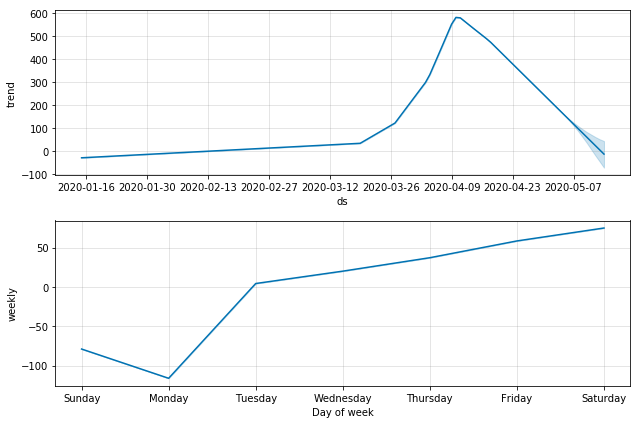

In [47]:
train_data = data.copy()
train_data = train_data.sort_values("確定日datetime")
train_data = train_data.rename(columns={'確定日datetime': 'ds', 'total': 'y'})
model = Prophet(changepoint_prior_scale=0.01)
model.fit(train_data[["ds", "y"]][:int(len(train_data[["ds", "y"]])  * 0.95)])

future_data = model.make_future_dataframe(periods=10, freq = 'd' )
forecast_data = model.predict(future_data)

model.plot(forecast_data)
model.plot_components(forecast_data)
plt.show()

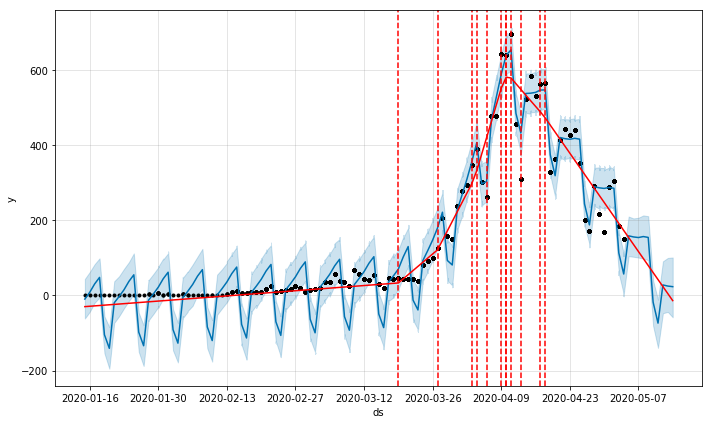

In [48]:
from fbprophet.plot import add_changepoints_to_plot
fig = model.plot(forecast_data)
a = add_changepoints_to_plot(fig.gca(), model, forecast_data)

# 週での感染者数

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 7.


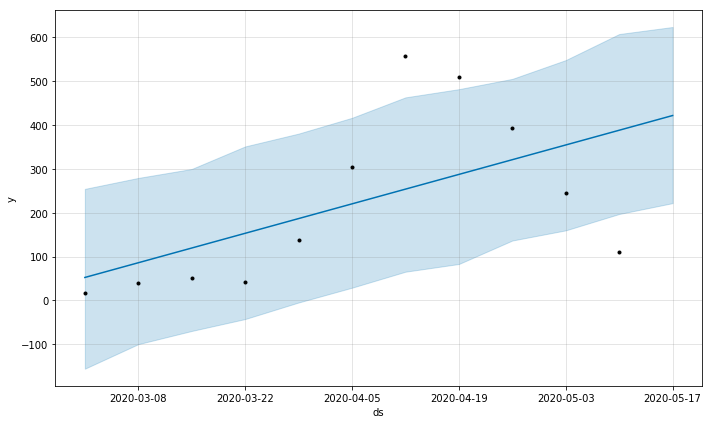

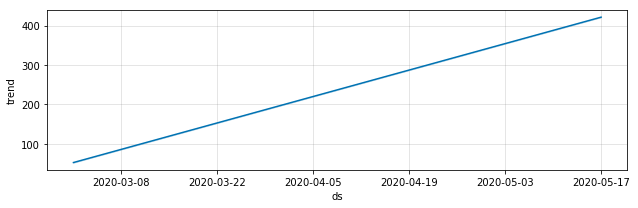

In [16]:
date_df = data.copy()
date_df = date_df.rename(columns={'確定日YYYYMMDD': 'ds', 'total': 'y'})
date_df["ds"] = [pd.to_datetime(i)for i in date_df["ds"]]
date_df = date_df[["ds", "y"]].set_index("ds").resample("W").mean().reset_index()

model = Prophet(changepoint_prior_scale=0.01)
model.fit(date_df[["ds", "y"]][6:-1])

future_data = model.make_future_dataframe(periods=1, freq = 'w' )
forecast_data = model.predict(future_data)

model.plot(forecast_data)
model.plot_components(forecast_data)
plt.show()

,ds,y,差分
0,2020-01-15,1,1.0
1,2020-01-16,2,1.0
2,2020-01-17,3,1.0
3,2020-01-18,4,1.0
4,2020-01-19,5,1.0
5,2020-01-20,6,1.0
6,2020-01-21,7,1.0
7,2020-01-22,8,1.0
8,2020-01-23,9,1.0
9,2020-01-24,10,1.0


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


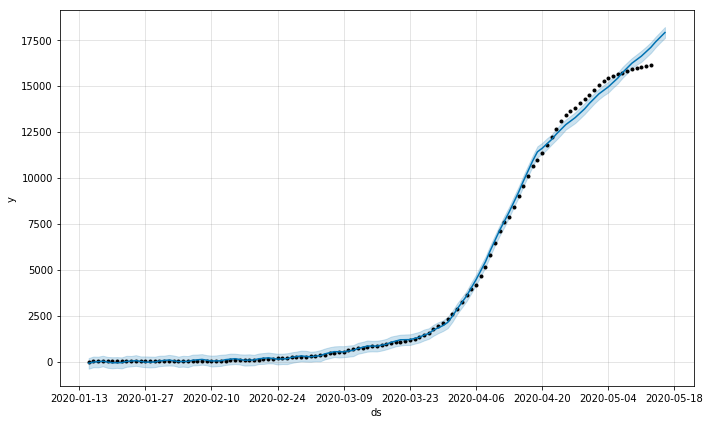

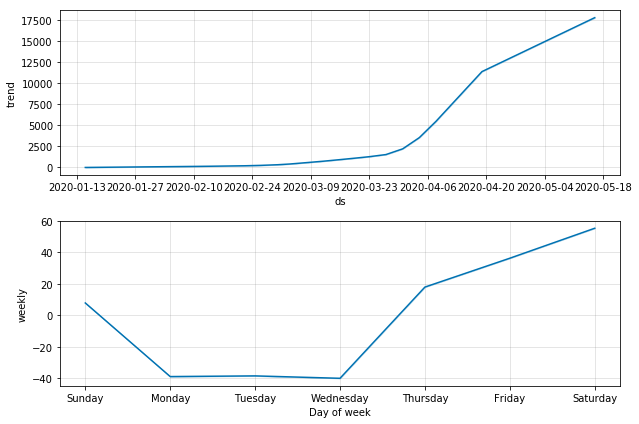

In [17]:
df_count_by_date = data[["人数", "確定日datetime"]].groupby("確定日datetime").count().reset_index()
date_df = data.copy()

sum_num = 0

def total_sum(n):
    global sum_num
    sum_num += n
    return sum_num

df_count_by_date["人数"] = [total_sum(df_count_by_date["人数"][i]) for i in range(len(df_count_by_date["人数"]) )]
difference = []

for i in range (1, len(df_count_by_date)):
    num = df_count_by_date["人数"][i] - df_count_by_date['人数'][i-1]
    difference.append(num)
difference.append(np.nan)
df_count_by_date["差分"] = difference

df_count_by_date = df_count_by_date.rename(columns={'確定日datetime': 'ds', '人数': 'y'})
display(df_count_by_date)

model = Prophet()
model.fit(df_count_by_date[["ds", "y"]][:-1])

future_data = model.make_future_dataframe(periods=3, freq = 'd' )
forecast_data = model.predict(future_data)

model.plot(forecast_data)
model.plot_components(forecast_data)
plt.show()

## 前日までの比較

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


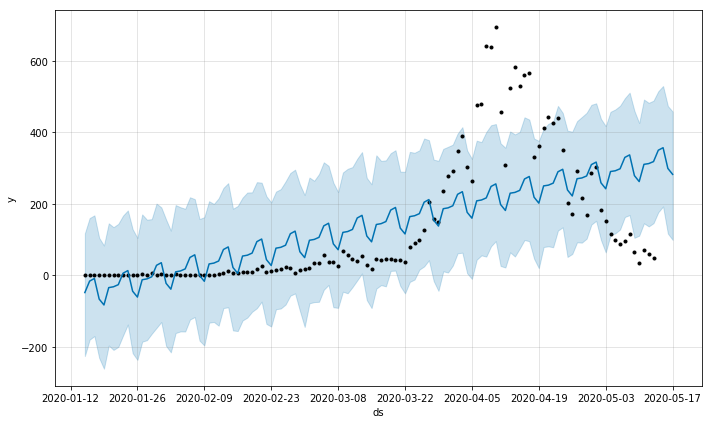

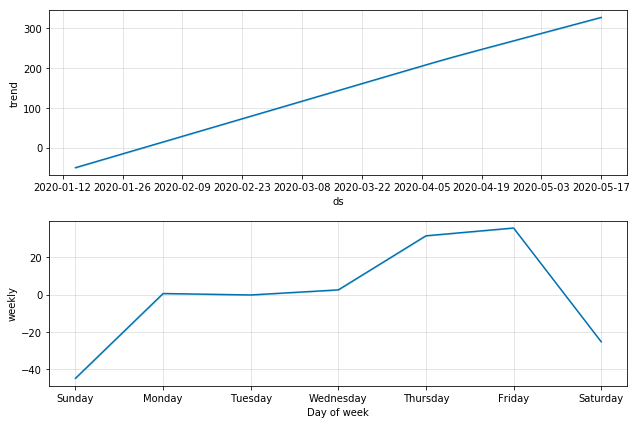

In [18]:
df_count_by_date = df_count_by_date.rename(columns={'y': 'total', '差分': 'y'})
model = Prophet()
model.fit(df_count_by_date)

future_data = model.make_future_dataframe(periods=3, freq = 'd')
forecast_data = model.predict(future_data)

model.plot(forecast_data)
model.plot_components(forecast_data)
plt.show()